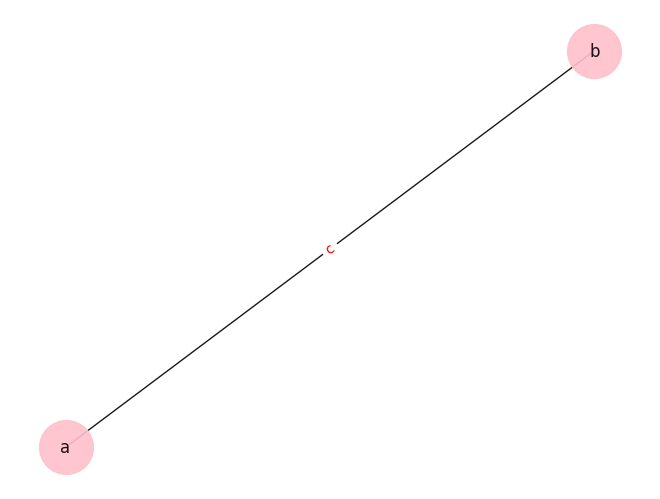

In [38]:
import networkx as nx
import matplotlib.pyplot as plt
import io
import numpy as np
 
def draw_graph2(obj_mapping, rels, rel_mapping):
    g = nx.Graph()
        
    for (a, b) in (rels):
        g.add_edge(a, b)

    pos = nx.spring_layout(g)

    nx.draw(
        g, pos, edge_color='black', width=1, linewidths=1,
        node_size=1500, node_color='pink', alpha=0.9,
        labels=obj_mapping
    )
    nx.draw_networkx_edge_labels(
        g, pos,
        edge_labels=rel_mapping,
        font_color='red'
    )
    io_buf = io.BytesIO()
    plt.savefig(io_buf, format='raw', dpi=100)
    fig = plt.gcf()
    io_buf.seek(0)
    img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                        newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
    io_buf.close()
    return img_arr

img = draw_graph2({0:'a', 1:'b'}, [(0, 1)], {(0, 1):'c'})

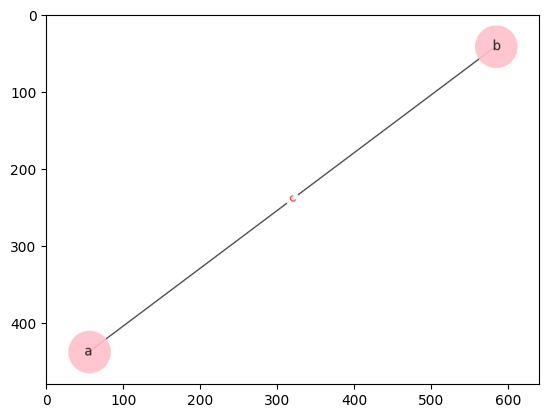

In [39]:
plt.imshow(img)

In [27]:
import matplotlib.pyplot as plt
from collections import defaultdict

import pandas as pd
import numpy as np
import os


fpath = "/vision/u/chpatel/sg3d/results.md"
with open(fpath, 'r') as fpt:
    lines = fpt.readlines()
for fpath in [
    "/vision/u/chpatel/test/mysg_detscratch_sgcls/",
    "/vision/u/chpatel/test/mysg_detscratch_sgcls_h3d/",
    "/vision/u/chpatel/test/mysg_detscratch_sgcls_imgh3d/",
#     "/vision/u/chpatel/test/mysg_detscratch_sgcls_lr1e4/",
#     "/vision/u/chpatel/test/mysg_detscratch_sgcls_h3d_lr1e4/",
    "/vision/u/chpatel/test/mysg_detr101scratch_sgcls/",
    "/vision/u/chpatel/test/mysg_detr101scratch_sgcls_h3d/",
    "/vision/u/chpatel/test/mysg_detr101scratch_sgcls_imgh3d/",
    "/vision/u/chpatel/test/mysg_detr101scratch_sgcls_addall/",
    "/vision/u/chpatel/test/mysg_detr101scratch_sgcls_imgh3d_addall/",
]:
    exp_name = os.path.basename(os.path.dirname(fpath))
    lines += [f"## {exp_name}"]
    with open(fpath + '/mylog.txt', 'r') as fpt:
        lines += fpt.readlines()

In [28]:
metric_types_all = ['R@10','R@20','R@50','R@100']
all_metrics = {
    'with constraint': {},
    'semi constraint': {},
    'no constraint': {},
}

exp_name = None
epoch = None
dct = None
sg_mode = None
metric_type, metric_value = None, None
constraint_type = None

def finishup():
    global exp_name, epoch, dct, sg_mode, metric_type, metric_value, constraint_type
    if exp_name is None:
        return
    
    for cty, dd in dct.items():
        if exp_name not in all_metrics[cty]:
            all_metrics[cty][exp_name] = {}
        all_metrics[cty][exp_name] = dd


    exp_name = None
    epoch = None
    dct = None
    sg_mode = None
    metric_type, metric_value = None, None
    constraint_type = None    

for ln in lines:
    ln = ln.strip()
    if not ln:
        continue
    if ln.startswith('##'):
        finishup()
        exp_name = ln[2:]
        dct = {}
        continue
    if ln.startswith('save the checkpoint'):
        epoch = ln.replace('save the checkpoint after ', '').replace(' epochs', '')
        epoch = int(epoch)
        continue
    if ln.startswith('==='):
        sg_mode = ln.replace('=', '')
        continue
    if ln.startswith('R@'):
        metric_type, metric_value = ln.split(' ')
        metric_type = metric_type.replace(':', '')
        if epoch is None: epoch = 9
        if constraint_type is None: constraint_type = 'with constraint'

        if constraint_type not in dct: dct[constraint_type] = {}
        if epoch not in dct[constraint_type]: dct[constraint_type][epoch] = {}
        dct[constraint_type][epoch][metric_type] = round(float(metric_value) * 100, 2)
    if ln.startswith('Epoch '): # lr reduction
        continue
    if ln.startswith('----'):
        constraint_type = ln.replace('-', '')
        continue
        

finishup()

def flatten_dict(nested_dict):
    res = {}
    if isinstance(nested_dict, dict):
        for k in nested_dict:
            flattened_dict = flatten_dict(nested_dict[k])
            for key, val in flattened_dict.items():
                key = list(key)
                key.insert(0, k)
                res[tuple(key)] = val
    else:
        res[()] = nested_dict
    return res


def nested_dict_to_df(values_dict):
    flat_dict = flatten_dict(values_dict)
    df = pd.DataFrame.from_dict(flat_dict, orient="index")
    index = pd.MultiIndex.from_tuples(df.index)
    df = pd.Series(df.values.reshape(-1), index=index)
    # df = df.unstack(level=-1)
    # df.columns = df.columns.map("{0[1]}".format)
    return df

new_metrics = {'exp name': []}
new_metrics.update({m: [] for m in metric_types_all})
for exp_name, res in all_metrics['with constraint'].items():
    
    epochs = list(res.keys())
    max_epoch_idx = np.argmax([v['R@50'] for k, v in res.items()])
    max_epoch = epochs[max_epoch_idx]
#     max_epoch = sorted(epochs)[-1]

    new_metrics['exp name'].append(exp_name)
    for m in metric_types_all:
        new_metrics[m].append(res[max_epoch][m])


df = pd.DataFrame(new_metrics, columns=['exp name',]+metric_types_all)
df = df.sort_values(df.columns[0], ascending = True)
formatters = {}
for col in df.select_dtypes("object"):
    len_max = df[col].str.len().max()
    formatters[col] = lambda _: f"{_:<{len_max}s}"
print(df.to_string(formatters=formatters, justify='left'))

   exp name                                                                 R@10   R@20   R@50   R@100
5    PredCLs my training                                                    66.47  69.54  69.56  69.56
6    PredCLs my training h3d                                                66.57  69.61  69.63  69.63
7    PredCLs my training img_h3d                                            66.43  69.48  69.49  69.49
17   PredCLs repo testing                                                   68.56  71.78  71.80  71.80
0    PredCLs repo training                                                  68.15  71.21  71.23  71.23
1    PredCLs repo training 1 epoch                                          60.46  63.50  63.52  63.52
3    PredCLs repo training h3d                                              68.24  71.33  71.35  71.35
4    PredCLs repo training img_h3d                                          68.49  71.64  71.66  71.66
2    PredCLs repo training without spatial mask                          

In [60]:
sdf = df.drop([13,1,2,8, 10, 9, 16, 11,12,14,15])
# sdf = df.drop([5,6,7,13,0,1,3,4,2,11,12,15,14])
from IPython.display import display, HTML
display(sdf)

,exp name,R@10,R@20,R@50,R@100
5,PredCLs my training,66.475,69.540,69.556,69.556
6,PredCLs my training h3d,66.574,69.608,69.625,69.625
7,PredCLs my training img_h3d,66.435,69.476,69.493,69.493
0,PredCLs repo training,68.146,71.210,71.229,71.229
3,PredCLs repo training h3d,68.242,71.333,71.351,71.351
4,PredCLs repo training img_h3d,68.491,71.639,71.656,71.656
